<h2><center>Docking ISS</center></h2>

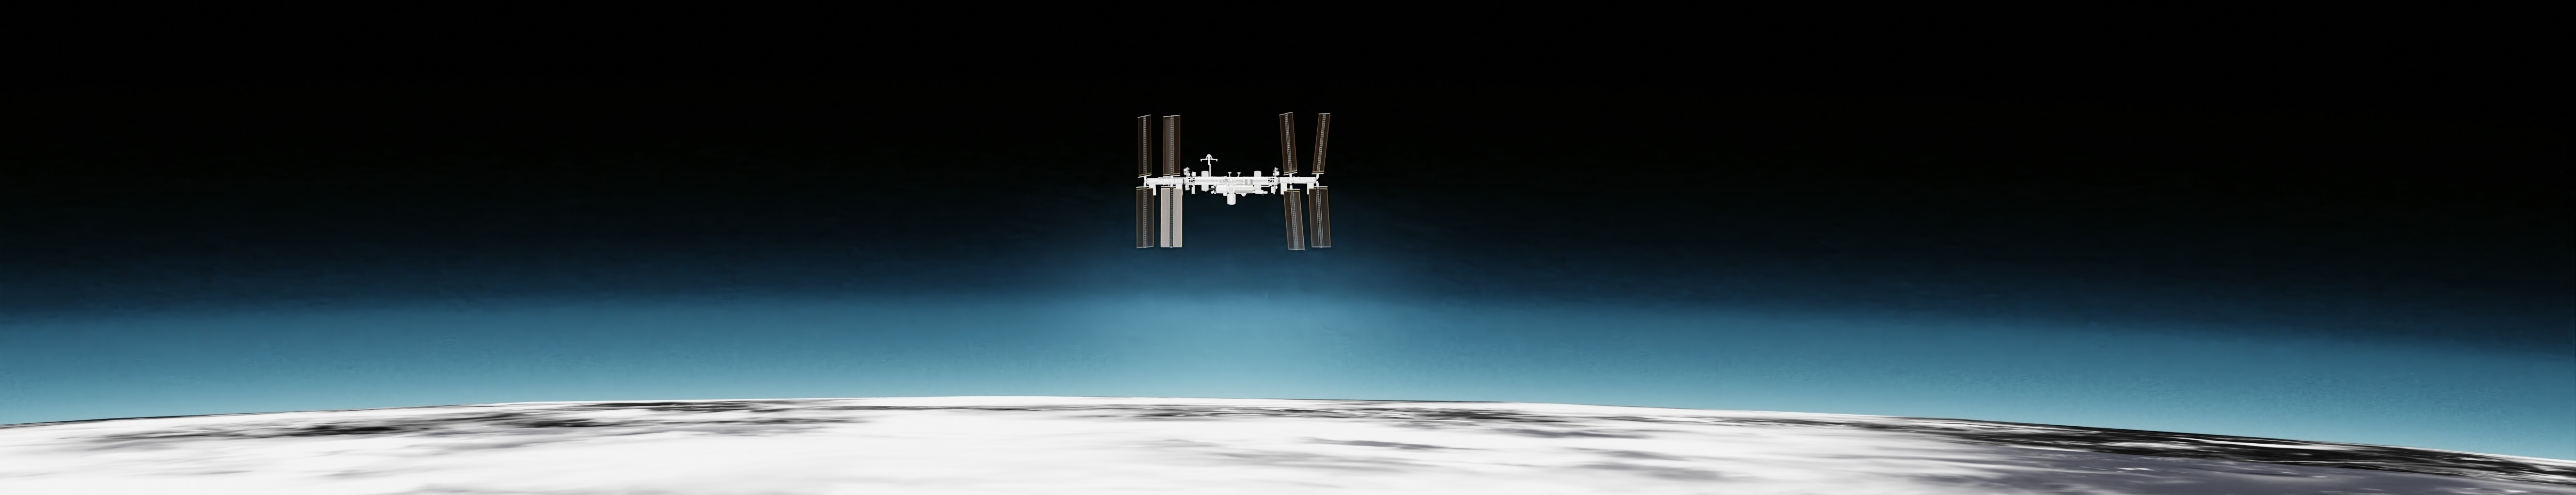

I used https://pytorch.org/vision/stable/models.html instead of pretrainedmodels.

# Setting up Environment

### Downloading Dataset

So we will first need to download the python library by AIcrowd that will allow us to download the dataset by just inputting the API key. 

In [ ]:
!pip install aicrowd-cli

%load_ext aicrowd.magic

In [ ]:
%aicrowd login --api-key API_KEY

In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c docking-iss -o data

In [ ]:
# Unzipping the files
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

### Downloading & Importing Libraries

Here we are going to use PyTorch to do our multioutput tasks, while [PyTorch](https://pytorch.org/) is really popular deep learning model, for those who are new to PyTorch, pytorch is an open source Deep Learning Library thay helps in creating, training Deep Learning Models, and much more. 

In [ ]:
# PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

# Pretrained Models
import torchvision.models as models
!pip install torchextractor

# Reading Dataset & Visualizations
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

# Misc
import os
from tqdm import trange
from tqdm.notebook import tqdm
import random

# Using GPU for training if GPU is detected, else, CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def seed_everything(seed):
  os.environ["PL_GLOBAL_SEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

seed_everything(1)

Make Sure your GPU is enabled by going in tab **Runtime** > **Change Runtime Type** > **Hardware Accelerator** > **GPU**

# Training phase ⚙️

## Reading Dataset

Reading the necessary files to train, validation & submit our results! 

In [ ]:
# Reading the training dataset
train_df = pd.read_csv("data/train.csv")
train_df

## Data Visualization

In [ ]:
# Reading a ramdom sample
sample_index = random.randint(0, train_df.shape[0]-1)

# Reading the image
img = Image.open(f"data/train/{train_df['ImageID'][sample_index]}.jpg")

# Getting the distance and location of the specific image
distance = train_df['distance'][sample_index]
location = eval(train_df['location'][sample_index])

# Drawing the location and the distance
draw = ImageDraw.Draw(img)
x, y, r = location[0], location[1], 3
points = (x-r, y-r, x+r, y+r)
draw.ellipse(points, "yellow")
draw.text((0, 0),f"Distance : {distance}","yellow")

img

## Creating the Dataset

In [ ]:
import torchvision.transforms as transforms

class ISSDataset(Dataset):

  def __init__(self, img_directory, csv_path=None, train=True):
    
    # Images directory and reading corrospoding csv
    self.img_directory = img_directory
    self.train = train
    self.data = pd.read_csv(csv_path)

  def __len__(self):
    return len(os.listdir(self.img_directory))

  def __getitem__(self, idx):

    img_id = self.data['ImageID'][idx]

    # Reading the image
    img_path = os.path.join(self.img_directory, f"{img_id}.jpg")
    img = Image.open(img_path)
    trans = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    img = trans(img)

    # If the dataset is set to train
    if self.train == True:
      
      # Reading the labels
      distance = self.data[self.data['ImageID'] == img_id]['distance'].values[0]
      location = eval(self.data[self.data['ImageID'] == img_id]['location'].values[0])

      label = [distance, location[0], location[1]]


      return img, label
    
    # If dataset is set to testing data
    else:

      return img, img_id

In [ ]:
# Reading the training dataset
train_iss_dataset = ISSDataset(csv_path="data/train.csv", img_directory="data/train/")
train_dataset = DataLoader(train_iss_dataset, batch_size=8, shuffle=True)

# Reading the validation dataset
val_iss_dataset = ISSDataset(csv_path="data/val.csv", img_directory="data/val/")
val_dataset = DataLoader(val_iss_dataset, batch_size=8, shuffle=True)

In [ ]:
# Going through a sample of the the dataset
feature, labels = next(iter(train_dataset))

In [ ]:
# Showing the image with label
img = np.moveaxis(feature[0].numpy(), 0, -1)
plt.imshow(img)
labels

## Creating the Model

Using a Pretrained Resnet18 model and adding three fully connected layers to predict - 
* Distance
* Location in X axis
* Location in Y axis

In [ ]:
import torchextractor as tx

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    # Using a pretrained mdoel
    self.model = models.resnet34(pretrained=True)
    self.ex_model = tx.Extractor(self.model, ["layer4.2.bn2"])

    # Creating 3 fully connected layers 
    self.distance_fc = nn.Linear(512, 1)
    self.location_fc_x = nn.Linear(512, 1)
    self.location_fc_y = nn.Linear(512, 1)

  # Taking the image and predicting the labels 
  def forward(self, image):  
    batch_size = image.shape[0]
    output, feature = self.ex_model(image)
    x = F.adaptive_avg_pool2d(feature["layer4.2.bn2"], 1).reshape(batch_size, -1)
    distance = self.distance_fc(x)
    location_x = self.location_fc_x(x)
    location_y = self.location_fc_y(x)

    return distance, location_x, location_y

model = Model()
model

In [ ]:
# Sample Predictions
model.to(device)
sample_predictions = model(feature.to(device))
sample_predictions

## Setting up Parameters

Here we will be setting up few parameters including Loss, Optimizer, Learning Rate and function for the trainign

In [ ]:
# Loss
loss_function = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
# Training Function 
def train(train_dataloader, val_dataloader, model, loss_function, optimizer, scheduler, epochs=1, early_stopping=3):

  # Using GPU if GPU is detected
  model = model.to(device)
  best_val = float('inf')
  prev_loss = float('inf')
  counter = 0

  model.train()
  for epoch in range(epochs):
    losses = []
    # train
    print(f"Training epoch {epoch}")
    pbar = tqdm(train_dataloader) # Creating a progress bar
    for batch, (X, y) in enumerate(train_dataloader):
      
      # Ground truth
      y = [i.to(torch.float32).to(device).unsqueeze(1) for i in y]

      # Predictions
      pred = model(X.to(device))
      pred = [i.to(torch.float32)  for i in pred]

      # Calulating total loss for 3 predictions
      loss = loss_function(y[0], pred[0]) + loss_function(y[1], pred[1]) + loss_function(y[2], pred[2])

      # Doing backpropagation if train is set to true
      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
      optimizer.step()

      # Updating the progress bar
      pbar.set_description(f"Batch : {batch} Loss : {loss.item()}")
      losses.append(loss.item())
      pbar.update(1)
    
    scheduler.step()
    avg_loss = sum(losses) / len(losses)
    print(avg_loss)

    if os.path.exists('last.pt'):
      os.remove('last.pt')
    torch.save(model.state_dict(), 'last.pt')

    # eval
    model.eval()
    losses = []
    print(f"Evaluating epoch {epoch}")
    pbar = tqdm(val_dataloader) # Creating a progress bar
    for batch, (X, y) in enumerate(val_dataloader):
      # Ground truth
      y = [i.to(torch.float32).to(device).unsqueeze(1) for i in y]

      # Predictions
      pred = model(X.to(device))
      pred = [i.to(torch.float32)  for i in pred]

      # Calulating total loss for 3 predictions
      loss = loss_function(y[0], pred[0]) + loss_function(y[1], pred[1]) + loss_function(y[2], pred[2])

      # Updating the progress bar
      pbar.set_description(f"Batch : {batch} Loss : {loss.item()}")
      losses.append(loss.item())
      pbar.update(1)

    avg_loss = sum(losses) / len(losses)
    print(avg_loss)

    # save best
    if avg_loss < best_val:
      if os.path.exists('best.pt'):
        os.remove('best.pt')
      print(f"Saving epoch {epoch} to best")
      torch.save(model.state_dict(), 'best.pt')
      best_val = avg_loss

    # early stopping
    if avg_loss < prev_loss:
      counter = 0
    else:
      counter += 1
    if counter == early_stopping:
      print('Early stopping')
      return
    prev_loss = avg_loss
    print()

## Training the Model
And there we go! It's finally the time to start the training!

In [ ]:
train(train_dataloader=train_dataset, val_dataloader=val_dataset, model=model, loss_function=loss_function, optimizer=optimizer, scheduler=scheduler, epochs=30, early_stopping=3)

In [ ]:
model.load_state_dict(torch.load("best.pt"))
model.eval()

In [ ]:
losses = []
for batch, (X, y) in enumerate(val_dataset):
  # Ground truth
  y = [i.to(torch.float32).to(device).unsqueeze(1) for i in y]

  # Predictions
  pred = model(X.to(device))
  pred = [i.to(torch.float32)  for i in pred]

  # Calulating total loss for 3 predictions
  loss = loss_function(y[0], pred[0]) + loss_function(y[1], pred[1]) + loss_function(y[2], pred[2])
  losses.append(loss.item())

avg_loss = sum(losses) / len(losses)
print(avg_loss)

# Submitting Results 📄

Okay, this is the last section 😌 , let's get out testing results from the model real quick and submit our prediction directly using AIcrowd CLI

## Reading the Test Dataset

In [ ]:
test_dataset = ISSDataset(img_directory="data/test/", csv_path="data/submission.csv", train=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Function to take the dataset & model and return the predictions for all samples
def test(dataloader, model):

  # Loss containing predictions
  distances = []
  locations = []
  imageids = []

  model = model.to(device)

  # Going through each batch  
  for batch, (X, img_id) in tqdm(enumerate(dataloader)):

    # Getting the predictions
    pred = model(X.to(device))

    # Adding the distance
    distance = pred[0].cpu().detach().tolist()
    distances.extend([*distance])
    
    # Adding the Locations 
    location_x = pred[1].cpu().detach().tolist()
    location_y = pred[2].cpu().detach().tolist()
    location = [[x[0], y[0]]  for x, y in zip(location_x, location_y)]
    locations.extend(location)

    imageids.extend([*img_id.tolist()])

  return imageids, [d[0] for d in distances], locations

In [ ]:
# Running the inference
imageids, distances, locations = test(test_dataloader, model)

In [ ]:
# Adding the predictions to the submission.csv 
test_dataset.data.ImageID = imageids
test_dataset.data.distance = distances
test_dataset.data.location = locations
test_dataset.data

In [ ]:
# Saving the submission.csv in the assets folder 
!rm -rf assets
!mkdir assets

test_dataset.data.to_csv(os.path.join("assets", "submission.csv"), index=False)

## Uploading the Results